# Associating Partial Charges
The MPNN takes a molecular graph as input, which we generate from the SMILES string.
The output for our network is the atomic charges, which are provided in the same order as the atoms in the XYZ file.
The problem is that the order of the atoms in the network defined by the SMILES are different than those in the XYZ file. 
We align those lists of atoms in this notebook and save the result in a way we can use it later.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patheffects as plt_pe
from jcesr_ml.benchmark import load_benchmark_data
from networkx.algorithms import isomorphism as ism
from pybel import readstring
from random import choices
from rdkit.Chem import AllChem
from rdkit import Chem
from multiprocessing import Pool
from tqdm import tqdm
import openbabel as ob
import networkx as nx
import pickle as pkl
import pandas as pd
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## Load in the Molecular data
We need all of it

In [2]:
data = pd.concat(load_benchmark_data())

## Make a Function to Move SMILES and XYZ files into Graphs
We want networkx graphs to make the alignment process easier

In [3]:
def networkx_from_smiles(smiles):
    """Generate a networkx graph from a SMILES sx`tring
    
    Adapted from: https://github.com/maxhodak/keras-molecules/blob/dbbb790e74e406faa70b13e8be8104d9e938eba2/convert_rdkit_to_networkx.py
    
    Args:
        smiles (str): SMILES string
    Returns:
        (nx.Graph) Graph structure
    """
    
    # Parse the molecule and add Hs
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    # Add molecules to the graph
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx())
    return G

In [4]:
def networkx_from_xyz(xyz):
    """Generate a networkx graph from a XYZ file
    
    Args:
        xyz (str): XYZ file
    Returns:
        (nx.Graph) Graph structure
    """
    
    # Parse the molecule
    mol = readstring('xyz', xyz)
    
    # Add molecules to the graph
    G = nx.Graph()
    for atom in mol.atoms:
        G.add_node(atom.idx - 1,
                   atomic_num=atom.atomicnum)
    for bond in ob.OBMolBondIter(mol.OBMol):
        G.add_edge(bond.GetBeginAtomIdx() - 1,
                   bond.GetEndAtomIdx() - 1)
    return G

In [5]:
def match_atoms(smiles, xyz):
    """Match the atoms from a SMILES and XYZ representation
    
    Args:
        smiles (str): SMILES representation
        xyz (str): XYZ file
    Returns:
        (dict) Mapping of atom ID in smiles to that in the XYZ
    """
    
    # Parse the molecules
    smiles_graph = networkx_from_smiles(smiles)
    xyz_graph = networkx_from_xyz(xyz)
    
    # Make the matching function
    gm = ism.GraphMatcher(smiles_graph, xyz_graph,
                          node_match=ism.categorical_node_match('atomic_num', -1))
    gm.is_isomorphic()
    return gm.mapping

In [6]:
def get_charges_for_smiles(row):
    """Get partial chargest for a ceratin SMILES string
    
    Matches the order of atoms to that in an XYZ
    
    Args:
        row (dict): Data about a certain molecule
    Returns: 
        - (str): Smiles string
        - (ndarray) Atomic charges
    """
    
    # Match the graphs
    mapping = match_atoms(row['smiles_0'], row['xyz'])
    
    # Apply the mapping
    charges = row['atomic_charges']
    output = np.zeros_like(charges)
    for k, v in mapping.items():
        output[k] = charges[v]
    return row['smiles_0'], output

## Run and Save Lookup Mapping
We are going to use the lookup table when training the models

In [7]:
charges_lookup = {}
data['mapped_charges'] = None
mapped_charges_list = []
for rid, row in tqdm(data.iterrows(), total=len(data)):
    smiles, mapped_charges = get_charges_for_smiles(row)
    charges_lookup[smiles] = mapped_charges
    mapped_charges_list.append(mapped_charges)

100%|██████████| 130258/130258 [13:59<00:00, 155.12it/s]


In [8]:
data['mapped_charges'] = mapped_charges_list

In [9]:
with open('mapped_charges.pkl', 'wb') as fp:
    pkl.dump(charges_lookup, fp)

Save the dataset with the revised charges

In [10]:
data.to_pickle('mapped_charges_dataset.pkl.gz')

## Plot a Few Molecules to Check Results
Make sure the mapped charges are reasonable

In [11]:
def generate_plot_components(smiles):
    """Generate the components needed to plot a certain SMILES string
    
    Args:
        smiles (str): SMILES string for a moleucule
    Returns:
        - (ndarray) 2D coordinates
        - ([(int, int, float)]) Bond information: Start/stop atom + type
        - ([str]) Element for each atom
    """
    
    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    # Compute coordinates
    AllChem.Compute2DCoords(mol)
    c = mol.GetConformer(0)
    
    # Prepare to store atom information
    n_atoms = mol.GetNumAtoms()
    symbols = [''] * n_atoms
    coords = np.zeros((n_atoms, 3))
    for atom in mol.GetAtoms():
        ix = atom.GetIdx()
        
        # Store the symbol
        symbols[ix] = atom.GetSymbol()
        
        # Store the coordinates
        ix_coords = c.GetAtomPosition(ix)
        coords[ix, 0] = ix_coords.x
        coords[ix, 1] = ix_coords.y
        coords[ix, 2] = ix_coords.z
    
    # Store the bond information
    bond_info = []
    for bond in mol.GetBonds():
        bond_info.append((bond.GetBeginAtomIdx(),
                          bond.GetEndAtomIdx(),
                          bond.GetBondTypeAsDouble()))
        
    return coords, bond_info, symbols

In [12]:
def plot_molecule(ax, smiles, charges):
    """Plot a molecule and the charges on each atom
    
    Args:
        ax: Pyplot access
        smiles (str): SMILES string for the molecule
        charges ([float]): Atomic charges on each molecule
    """
    
    # Get the atom positions
    coords, bond_info, symbols = generate_plot_components(smiles)
    
    # Plot the bonds
    for bond in bond_info:
        sx, ex, lw = bond
        ax.plot(coords[[sx, ex], 0], coords[[sx, ex], 1],
                color='k', zorder=0, lw=lw ** 2)
    
    # Plot the atomic charges
    scale = np.abs(charges).max()
    ax.scatter(coords[:, 0], coords[:, 1], c=charges, 
               vmax=scale, vmin=-scale,
               cmap='bwr', s=150, edgecolors='k')
    
    # Add atom labels
    for i, s in enumerate(symbols):
        ax.text(coords[i, 0], coords[i, 1], s,
               ha='center', va='center',
               path_effects=[plt_pe.withStroke(linewidth=2, foreground='w')])

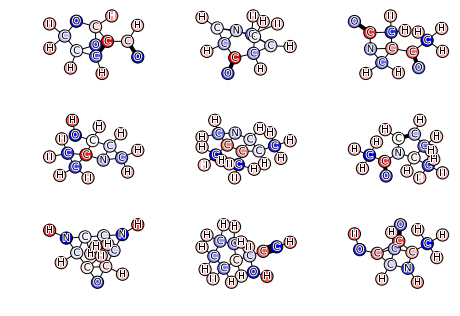

In [13]:
fig, axs = plt.subplots(3, 3)

for (s, c), ax in zip(choices(list(charges_lookup.items()), k=axs.size), axs.flatten()):
    plot_molecule(ax, s, c)
    ax.set_axis_off()
    
fig.set_size_inches(6.5, 4.5)
fig.tight_layout()

They seem reasonable for a series of random selections. Oxygen atoms are often more negatively charged (blue) whatever they are bonded to